# AI LAB 4: TRANSFER LEARNING

**ResNet50 Multiclass Classification**


### Библиотеки и установка зависимостей

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
DATA_MODES = ['train', 'val']
RESCALE_SIZE = 224
DEVICE = torch.device("cpu")
BIN = False
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")

In [ ]:
def checkBin(filename):
    if filename[0].islower():
        return "Dog"
    return "Cat"

In [ ]:
class PetFacesDataset(Dataset):
    def __init__(self, files, mode, bin=False):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.bin = bin

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            if self.bin:
                self.labels = [checkBin(path.name) for path in self.files]
            else:
                self.labels = ["_".join(path.name.split("_")[0:-1]) for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAutocontrast(),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
root = './'
_ = OxfordIIITPet(root, download=True)

In [ ]:
DIR = Path('./oxford-iiit-pet/images')

files = sorted(list(DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

if BIN:
    y = [checkBin(path.name) for path in files]
else:
    y = ["_".join(path.name.split("_")[0:-1]) for path in files]
print(y)

train_data, val_data = train_test_split(files, train_size=0.8, stratify=y)

['Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abys

In [ ]:
train_dataset = PetFacesDataset(train_data, "train", bin=BIN)
val_dataset   = PetFacesDataset(val_data, "val", bin=BIN)

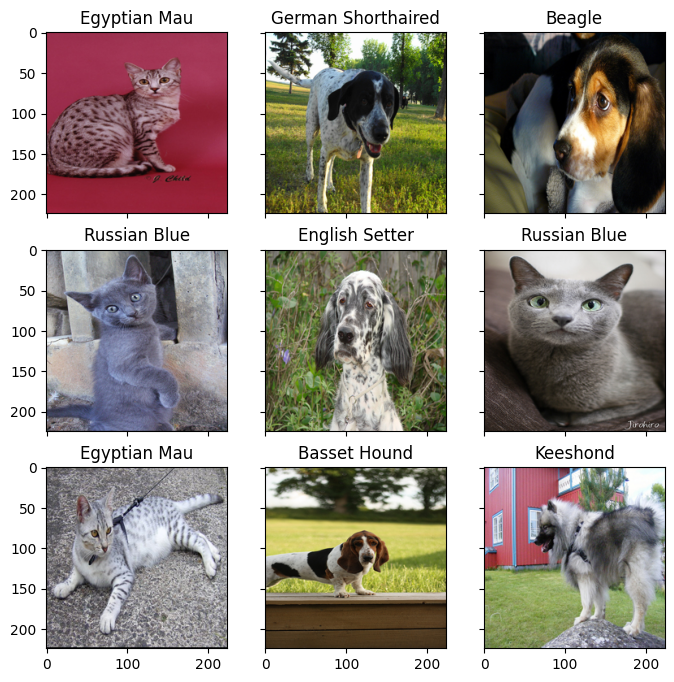

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Код для обучения модели

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0.0
    processed_data = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    running_corrects_top3 = 0.0
    running_corrects_top5 = 0.0
    processed_size = 0.0
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            preds_top3 = preds
            preds_top5 = preds
            try:
                preds_top3 = torch.topk(outputs, 3).indices
                preds_top5 = torch.topk(outputs, 5).indices
            except:
                "ok"
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        for i in range(len(labels.data)):
            if labels.data[i] in preds_top3[i]:
                running_corrects_top3 += 1
                # print(labels.data[i])
                # print(preds_top3[i])
        for i in range(len(labels.data)):
            if labels.data[i] in preds_top5[i]:
                running_corrects_top5 += 1
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    val_acc_top3 = running_corrects_top3 / processed_size
    val_acc_top5 = running_corrects_top5 / processed_size
    return val_loss, val_acc, val_acc_top3, val_acc_top5

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} \
    train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} \
    val_acc_top3 {v_acc_3:0.4f} val_acc_top5 {v_acc_5:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            model.eval()
            val_loss, val_acc, val_acc_3, val_acc_5 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc, val_acc_3, val_acc_5))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, v_acc_3=val_acc_3,\
            v_acc_5=val_acc_5))
    return history

In [ ]:
def predict(model, test_loader):
    logits = []
    with torch.inference_mode():
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Обучение

Посмотрим на количество данных и число классов.

In [ ]:
print(f"Количествово классов: {len(np.unique(np.array(y)))}")
print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

Количествово классов: 37
Размер обучающей выборки: 5912
Размер валидационной выборки: 1478


В этом блокноте рассматривается **ResNet50** для **мультиклассовой** классификации

In [ ]:
model = torchvision.models.resnet50(weights="IMAGENET1K_V2")
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Поменяем выход последнего слоя на количество классов (в нашем случае - 37)

In [ ]:
model.fc = nn.Linear(2048, len(np.unique(np.array(y))))

In [ ]:
model = model.to(DEVICE)

Обучаем сеть

In [19]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=128)

epoch:  10%|█         | 1/10 [02:36<23:27, 156.44s/it]


Epoch 001 train_loss: 1.1670 val_loss 0.8792     train_acc 0.6729 val_acc 0.7294     val_acc_top3 0.9276 val_acc_top5 0.9648


epoch:  20%|██        | 2/10 [05:20<21:25, 160.74s/it]


Epoch 002 train_loss: 0.6159 val_loss 0.9654     train_acc 0.8111 val_acc 0.7050     val_acc_top3 0.9019 val_acc_top5 0.9499


epoch:  30%|███       | 3/10 [07:47<18:03, 154.73s/it]


Epoch 003 train_loss: 0.4146 val_loss 0.7178     train_acc 0.8711 val_acc 0.7848     val_acc_top3 0.9411 val_acc_top5 0.9729


epoch:  40%|████      | 4/10 [10:17<15:16, 152.79s/it]


Epoch 004 train_loss: 0.3238 val_loss 0.7473     train_acc 0.8950 val_acc 0.7828     val_acc_top3 0.9290 val_acc_top5 0.9682


epoch:  50%|█████     | 5/10 [12:40<12:26, 149.20s/it]


Epoch 005 train_loss: 0.1438 val_loss 0.3596     train_acc 0.9584 val_acc 0.8978     val_acc_top3 0.9790 val_acc_top5 0.9878


epoch:  60%|██████    | 6/10 [14:58<09:42, 145.57s/it]


Epoch 006 train_loss: 0.0618 val_loss 0.3396     train_acc 0.9849 val_acc 0.9026     val_acc_top3 0.9790 val_acc_top5 0.9878


epoch:  70%|███████   | 7/10 [17:17<07:09, 143.14s/it]


Epoch 007 train_loss: 0.0455 val_loss 0.3293     train_acc 0.9880 val_acc 0.9073     val_acc_top3 0.9811 val_acc_top5 0.9899


epoch:  80%|████████  | 8/10 [19:34<04:42, 141.35s/it]


Epoch 008 train_loss: 0.0360 val_loss 0.3299     train_acc 0.9914 val_acc 0.9066     val_acc_top3 0.9817 val_acc_top5 0.9905


epoch:  90%|█████████ | 9/10 [21:52<02:20, 140.28s/it]


Epoch 009 train_loss: 0.0250 val_loss 0.3305     train_acc 0.9956 val_acc 0.9073     val_acc_top3 0.9817 val_acc_top5 0.9892


epoch: 100%|██████████| 10/10 [24:09<00:00, 144.91s/it]


Epoch 010 train_loss: 0.0239 val_loss 0.3308     train_acc 0.9953 val_acc 0.9053     val_acc_top3 0.9824 val_acc_top5 0.9899


Построим кривые обучения

In [20]:
loss, acc, val_loss, val_acc, val_acc_3, val_acc_5 = zip(*history)

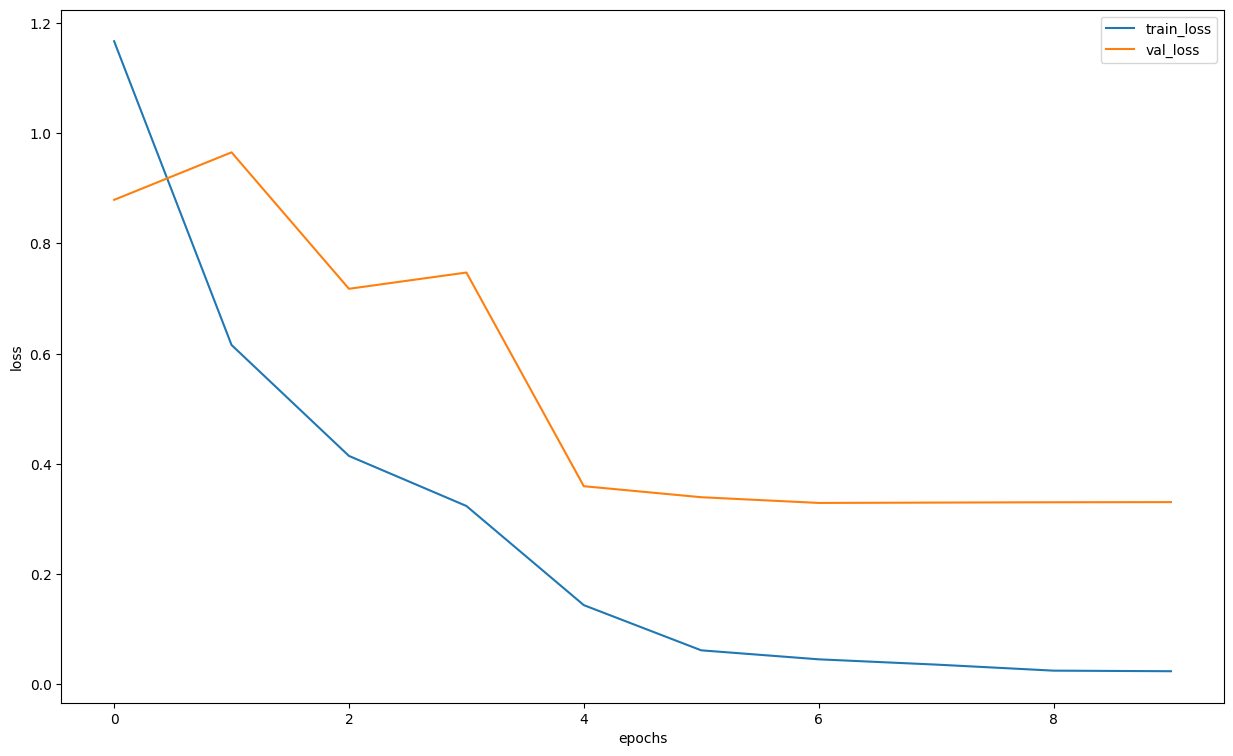

In [21]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

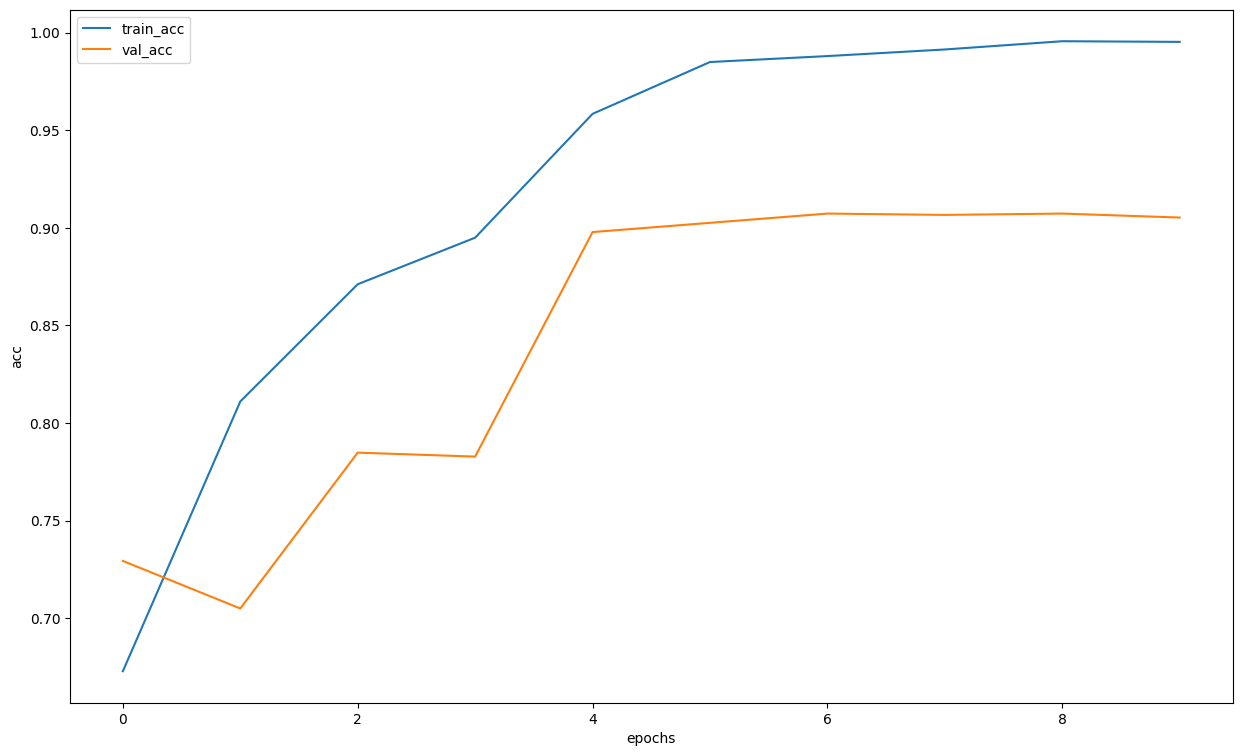

In [22]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Визуализация предсказаний нейронной сети

In [23]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.inference_mode():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

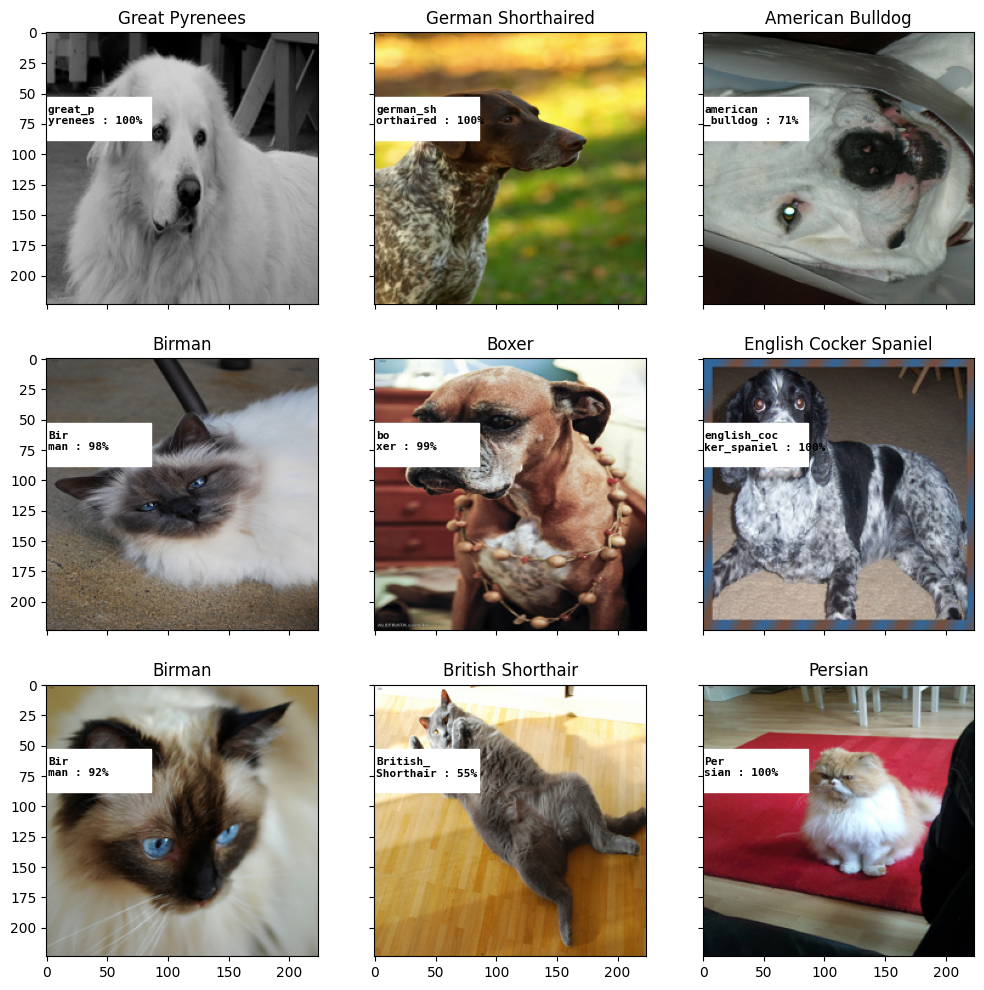

In [24]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("monospace")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label) // 2] + '\n' + predicted_label[len(predicted_label) // 2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
                    verticalalignment='top', fontsize=8, color='black', fontweight='bold')

## Confusion matrix

Матрица ошибок (Confusion matrix) --- это важный инструмент, который используется для оценки производительности модели классификации. Она представляет собой таблицу, которая позволяет визуализировать и анализировать результаты классификации на основе истинных и предсказанных значений.

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [26]:
idxs = list(range(0, len(val_dataset)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)
y_real = [val_dataset[id][1] for id in idxs]
y_pred = torch.Tensor(probs_ims).argmax(dim=1).tolist()

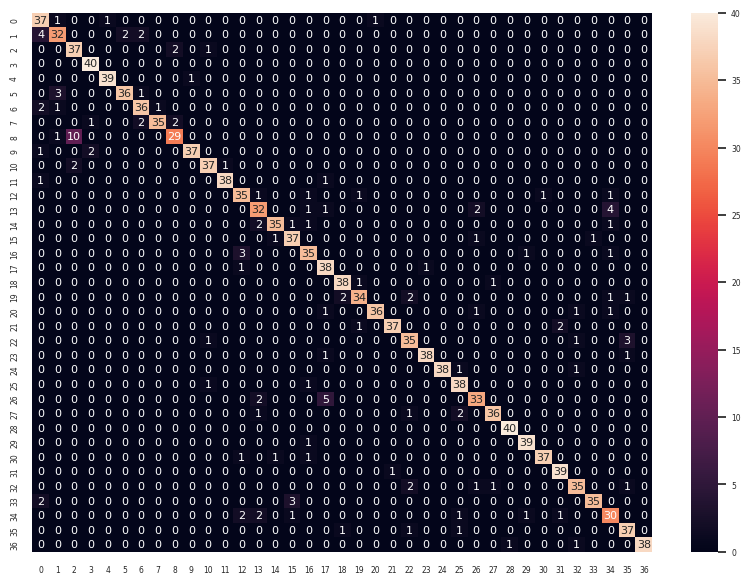

In [27]:
array = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(array, range(37), range(37))
plt.figure(figsize=(10, 7))
sn.set(font_scale=0.5)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})
plt.show()

#### Соотношения классов с лейблами


In [28]:
[x for x in zip(train_dataset.label_encoder.classes_,
train_dataset.label_encoder.transform(list(train_dataset.label_encoder.classes_)))]

[('Abyssinian', 0),
 ('Bengal', 1),
 ('Birman', 2),
 ('Bombay', 3),
 ('British_Shorthair', 4),
 ('Egyptian_Mau', 5),
 ('Maine_Coon', 6),
 ('Persian', 7),
 ('Ragdoll', 8),
 ('Russian_Blue', 9),
 ('Siamese', 10),
 ('Sphynx', 11),
 ('american_bulldog', 12),
 ('american_pit_bull_terrier', 13),
 ('basset_hound', 14),
 ('beagle', 15),
 ('boxer', 16),
 ('chihuahua', 17),
 ('english_cocker_spaniel', 18),
 ('english_setter', 19),
 ('german_shorthaired', 20),
 ('great_pyrenees', 21),
 ('havanese', 22),
 ('japanese_chin', 23),
 ('keeshond', 24),
 ('leonberger', 25),
 ('miniature_pinscher', 26),
 ('newfoundland', 27),
 ('pomeranian', 28),
 ('pug', 29),
 ('saint_bernard', 30),
 ('samoyed', 31),
 ('scottish_terrier', 32),
 ('shiba_inu', 33),
 ('staffordshire_bull_terrier', 34),
 ('wheaten_terrier', 35),
 ('yorkshire_terrier', 36)]